In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import cache_magic
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go
import concurrent.futures
from copy import deepcopy

from tracking_v2.target import ConstantVelocityTarget, SingleTurnTarget
from tracking_v2.kalman import LinearKalmanFilter, CoordinatedTurn
from tracking_v2.motion import ConstantVelocityModel, ConstantAccelerationModel, SingerAccelerationModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import Runner, evaluate_nees, plot_error, plot_3d

from tracking.util import to_df

%cache magic is now registered in ipython


In [ ]:
def normalize(v):
    return np.asarray(v) / np.linarg.norm(v)

def project(p, l0, l1):
    p, l0, l1 = np.asarray(p), np.asarray(l0), np.asarray(l1)
    line = l1 - l0
    
    np_dot_line = np.dot(line, line)
    if np_dot_line == 0:
        return l1

    # L = dot(p-l0, line) / np.linarg.norm(line) is the length of the projection of p-l0 onto line
    # X = line / np.linarg(line) is the direction unit vector of line
    # P = l0 + X*L is the projection of point 'p' onto line
    # norm used twice is collapsed into dot(line, line)
    return l0 + np.dot(p - l0, line) / np_dot_line * line

In [4]:
class TurningMover:
    def __init__(self, initial_position, initial_velocity, mass, thrust_force, drag_coefficient):
        """
        Initialize the air vehicle mover.
        
        :param initial_position: Initial 3D position vector (x, y, z)
        :param initial_velocity: Initial 3D velocity vector (vx, vy, vz)
        :param mass: Mass of the vehicle in kg
        :param thrust_force: Maximum thrust force in Newtons
        :param drag_coefficient: Drag coefficient (dimensionless)
        """
        self.position = np.asarray(initial_position, dtype=float)
        self.velocity = np.asarray(initial_velocity, dtype=float)
        self.mass = mass
        self.thrust_force = thrust_force
        self.drag_coefficient = drag_coefficient
        self.theta 
        
        self.previous_position = np.asarray(initial_position, dtype=float)
                
    def update(self, dt, target, randomness_scale=1.0):
        """
        Update the vehicle's position and velocity for one time step.

        :param dt: Time step in seconds
        :param requested_heading: Desired heading as a unit vector (x, y, z)
        :param randomness_scale: Scale for random acceleration, affects how much the velocity changes randomly
        """

        # 

        

        # generic information used below
        
        path_vector     = target - self.initial_position
        path_direction  = path_vector / np.linalg.norm(path_vector)
        movement_vector = target - self.position

        speed = np.linalg.norm(self.velocity)
        distance_in_one_step = speed * dt
        distance_in_one_step_at_45_deg = np.sqrt(2) / 2 * distance_in_one_step
        
        # calculate the cross-track error: the distance between the current position
        # of the mover and the line defined by its initial position and the target

        mover_direction_projected_on_path_direction = path_vector * \
            np.dot(path_vector, movement_vector) / np.dot(path_vector, path_vector)
        
        mover_position_projected_on_path = target - mover_direction_projected_on_path_direction        
        mover_to_its_projection_path = mover_position_projected_on_path - self.position

        cross_track_error = np.linalg.norm(mover_to_its_projection_path)

        # if the movement in a single time step at 45 deg towards the path is larger
        # than cross-track error, find the angle which brings the mover exactly on the path
        if distance_in_one_step_at_45_deg > cross_track_error:
            distance_along_path   = np.sqrt(distance_in_one_step*distance_in_one_step - cross_track_error*cross_track_error)
            expected_new_position_in_one_step = mover_position_projected_on_path + path_direction * distance_along_path

        # it is impossible to close the x-track error in a single step, at at most a 45 deg
        # angle towards the path; change direction to 45 deg towards the path and move; this
        # balances the need to get back on the path with the need to move towards the target
        else:
            mover_to_path_direction = mover_to_its_projection_path / np.linalg.norm(mover_to_its_projection_path)
            expected_new_position_in_one_step = self.position + (mover_to_path_direction + path_direction) * distance_in_one_step_at_45_deg

        # calculation above assume displacement in a single time step, dt; the actual
        # velocity is x / dt
        self.velocity = (expected_new_position_in_one_step - self.position) / dt
        
        # velocity changes in direction but not in magnitute
        assert np.allclose(np.linalg.norm(self.velocity), speed, .001)

        
        # Calculate direction towards target
        direction_to_target = target - self.position
        distance_to_target = np.linalg.norm(direction_to_target)
        
        # Normalize direction vector
        if distance_to_target == 0:
            return True
        
        direction_to_target /= distance_to_target
        
        # Calculate drag force
        drag_force = -0.5 * self.drag_coefficient * np.linalg.norm(self.velocity) * self.velocity
        
        # Random acceleration (normally distributed)
        random_acceleration = np.random.normal(0, randomness_scale, 3)
        
        # Net acceleration
        net_acceleration = (self.thrust_force * direction_to_target / self.mass + 
                            drag_force / self.mass + 
                            random_acceleration)
        
        # Update velocity, trying to move towards the target
        self.velocity += net_acceleration * dt

        # Update position
        self.position = self.position + self.velocity * dt
        
        # Define the normal vector for the plane which defines the end of this leg
        normal = target - self.initial_position
        
        # if cosinus between these two vectors is negative, we moved past the target
        if np.dot(normal, target - self.position) < 0:
            self.initial_position = self.position
            return True
        
        return False
        

    def get_state(self):
        """
        Return the current state of the vehicle.
        
        :return: Tuple of (position, velocity)
        """
        return self.position, self.velocity
    
    def simulate(self, dt=.1, t_max=100):
        initial_pos = [0, 0, 0]  # Starting at origin
        initial_vel = [10, 0, 0]  # Moving initially along x-axis
        target = np.array([2000, 0, 0])

        trace = []
        for t in np.arange(0, t_max, dt):
            vehicle.update(dt, target)
            position, velocity = vehicle.get_state()
            trace.append(np.concatenate(([t], position, velocity)))

        return np.asarray(trace)

In [20]:
vehicle = AirVehicleMover2([0, 0, 0], [1, 0, 0], mass=1000, thrust_force=5000, drag_coefficient=0.05)
trace   = vehicle.simulate(t_max=400)
df      = to_df(trace, columns=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz'])

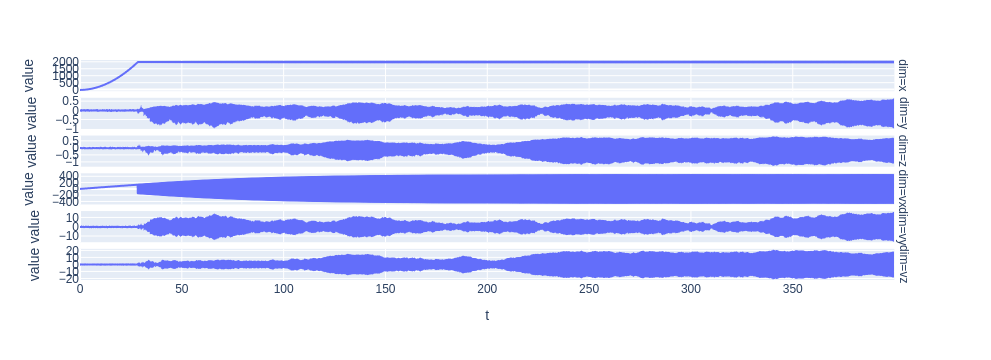

In [21]:
fig = ex.line(df.melt(['t'], ['x', 'y', 'z', 'vx', 'vy', 'vz'], 'dim', 'value'), x='t', y='value', facet_row='dim')
fig.update_yaxes(matches=None)
fig.update_layout(height=1000)
fig